# CMFD Evaluation Notebook

This notebook evaluate the CMFD method of [1] using two approaches, with some modification provided by Prof. Verdoliva et al. to scientific figures:
1. Zernike Features with PatchMatch [1]
2. Fusion of Zernike and Sift Features with PatchMatch

We run the approaches above on a subset of figures with pixwise annotations ( binary map )
    
 ### Reference
 [1] D.Cozzolino, G.Poggi, L.Verdoliva, ''Efficient dense-field copy-move forgery detection'', IEEE TIFS 2015.
 
 
 

## <mark>TODO</mark> Instructions

This notebook uses some MATLAB scripts and a docker provided by UNINA to accomplish its tasks. Please make sure to install it properly

**Import Cell**

In [1]:
from glob import glob
import tempfile
import os
import subprocess
from tqdm import tqdm
import shutil
import cv2
from PIL import Image
import numpy as np
import h5py
import json
import shutil
import pandas as pd
# Enviromnent Variables used in the matlab scripts
LIB_PATH = "unina_forensic_matlab"
os.environ['LD_LIBRARY_PATH'] = os.path.realpath("unina_forensic_matlab/dependencies")

## CMFD Experiment Setup

In [2]:
with open('cmfd-pixwise.json','r') as js:
    cmfd_pixwise_setup = json.load(js)

In [4]:
# Organize all ground-truths inside the experiment enviroment
for case in cmfd_pixwise_setup.keys():
    os.makedirs(f'cmfd_exp/pixwise/{case}',exist_ok=True)
    
    # copy gt to the env
    src_file = cmfd_pixwise_setup[case]['groundtruth-path']
    dest_file = f'cmfd_exp/pixwise/{case}/gt_' + os.path.basename(src_file)[:]
    shutil.copy(src_file,dest_file)
    
    # copy fig to the env
    src_file = cmfd_pixwise_setup[case]['figure-path']
    dest_file = f'cmfd_exp/pixwise/{case}/{os.path.basename(src_file)}'
    shutil.copy(src_file,dest_file)
     
    

# Functions Declarations

In [5]:
# Declaration of functions

def pm_zernike(img, tmpdir):
    cmd = f"docker run -v {tmpdir}:/data pm-sci-int data/{img} data/out.png"
    return subprocess.run(cmd, shell=True)

def cmfd_zernike(dataset):
    """
    Execute the CMFD [1] method with zernike features on each figure from the dataset. Saving the results on the cmfd-exp environment
    """
    # Execute the method for each image of the dataset
    for fig in tqdm(dataset):
        
        # Create a temporary directory to execute the detection
        # After this execution, all the result files will be saved on the cmfd-exp/pixwise directory
        with tempfile.TemporaryDirectory() as tmpdir:
            
            # Copy the img case to tempdir
            src = fig
            dest = f'{tmpdir}/{os.path.basename(fig)}'
            shutil.copy(src,dest)
            # Execute the CMFD method
            return_exec = pm_zernike(os.path.basename(fig), tmpdir)
    
            # Copy results to the original dataset location at the output dir
            # Result will be saved in the same directory of the input
            outdir = os.path.dirname(src) 
            
            dest = os.path.basename(src)
            dest = "".join(dest.split(".")[:-1])
            
            # Copy result to dest
            os.makedirs(f"{outdir}/zernikePM/", exist_ok=True)
            shutil.copy(f'{tmpdir}/out.png', f'{outdir}/zernikePM/{dest}_out.png')
            shutil.copy(f'{tmpdir}/out_col.png', f'{outdir}/zernikePM/{dest}_out_col.png')         
            
##################################################
##             USING Fusion           ############
##################################################
def create_result_map(img_map):
    resultMap = np.zeros((img_map.shape[0],img_map.shape[1]))
    for i in range(img_map.shape[2]):
        label = i+1
        resultMap[img_map[:,:,i] == 1] = label
    return resultMap
    
    
def matlab_cmfd_fusion(filename_imgA):
    """
    Wrap of a MatLab implementation of Zernike and Sift Features
    with PatchMatch for CMFD
    """
    # The implementation extract the SIFT features and keep them on a directory named as 'tmp'
    os.makedirs("tmp",exist_ok=True)
    with tempfile.NamedTemporaryFile('w+b', suffix='.hdf5') as tmpfile:
            cmd = "matlab -nodisplay -r \"run('%s/addpath_sift_forensic.m');try main_cmfd_keypoint_based('%s','%s'); catch; end; quit\""%(LIB_PATH, filename_imgA, tmpfile.name)
            subprocess.run(cmd, shell=True)
            try:
                with h5py.File(tmpfile.name, 'r') as f:
                    mapA = f['/mapA'][()]
                    num_gt = int(f['/num_gt'][()])
            # If the method fails
            except:
                num_gt = 0
    shutil.rmtree('tmp')

    if num_gt>0:
        if mapA.ndim==2:
            mapA = mapA[None,:,:]
        mapA = np.transpose(mapA,(2,1,0)).copy()
        
        resultA = create_result_map(mapA)
        
        return  resultA
    
    # return zeros maps
    imgA = Image.open(filename_imgA)
    resultA = np.zeros((imgA.height,imgA.width))
    
    return resultA
    
def cmfd_fusion(dataset):
    """
    Execute the CMFD method on muti figure cases using the fusion approach
    """
    # Execute the method for each pair of image case on the dataset
    for fig in tqdm(dataset):
        
        # Ger result map from fusion
        resutMap= matlab_cmfd_fusion(fig)
        
        resutMapImg = Image.fromarray(resutMap).convert("L")
        
        # Create dir
        src = fig
        outdir = os.path.dirname(src) 
        os.makedirs(f"{outdir}/fusionPM/", exist_ok=True)
        
        # Save labeled maps
        dest = os.path.basename(src)
        dest = "".join(dest.split(".")[:-1])
        # A map in which the background is zero and each detected region is labeled with its match with an ID, where ID in [1,inf]
        resutMapImg.save(f'{outdir}/fusionPM/{dest}_obj_labeled.png')
        
        # Save maps without label
        result_output = np.ones_like(resutMap)*255
        result_output[resutMap>0] = 0
        
        
        resutMapImg = Image.fromarray(result_output).convert("L")
        # Save unlabeled maps
        resutMapImg.save(f'{outdir}/fusionPM/{dest}_out.png')



# Running methods


In [6]:
# Collect all figures
pixwise_imgs = [ f"cmfd_exp/pixwise/{case}/{os.path.basename(cmfd_pixwise_setup[case]['figure-path'])}" for case in cmfd_pixwise_setup.keys()]
pixwise_imgs.sort()

In [7]:
# Apply pm-zernike method
cmfd_zernike(pixwise_imgs)

100%|██████████| 86/86 [38:37<00:00, 26.95s/it]


In [8]:
# Apply pm-fusion method
cmfd_fusion(pixwise_imgs)

100%|██████████| 86/86 [26:58<00:00, 18.82s/it]


------

# Evaluation


**Evaluation functions**

In [126]:

def evaluate_pixwise(gt_path, detected_path, method, case):
    
    # Read images
    gt = cv2.imread(gt_path,cv2.IMREAD_GRAYSCALE)
    detected = cv2.imread(detected_path,cv2.IMREAD_GRAYSCALE)

    # Normalize gt
    #gmin, gmax, _,_ = cv2.minMaxLoc(gt)
    # Considering White pixels as positive class
    gt = cv2.threshold(gt,0,1,cv2.THRESH_BINARY_INV)[1]

    # Normalize detect
    #dmin, dmax, _,_ = cv2.minMaxLoc(detected)
    # Considering White pixels as positive class
    detected = cv2.threshold(detected,0,1,cv2.THRESH_BINARY_INV)[1]

    # Tranform data to float
    gt = gt.astype(np.float32)
    detected = detected.astype(np.float32)

    # False Positive
    false_positive = detected - gt
    false_positive[false_positive<0] = 0

    # True Positive
    true_positive = detected - false_positive
    true_positive[true_positive<0] = 0

    # Metrics
    total = gt.shape[0]*gt.shape[1]
    npositive = gt.sum()
    nnegative = total - npositive

    ntruepos = true_positive.sum()
    nfalsepos = false_positive.sum()
    ntrueneg = nnegative - nfalsepos
    nfalseneg = npositive - ntruepos
    nposdetected = ntruepos + nfalsepos
    nnegdetected = ntrueneg + nfalseneg

    # Rate scores
    trueposrate = 0;
    if (npositive > 0):
            trueposrate = ntruepos / npositive;
    truenegrate = 0;
    if (nnegative > 0):
            truenegrate = ntrueneg / nnegative;
    falseposrate = 0;
    if (nnegative > 0):
            falseposrate = nfalsepos / nnegative;
    falsenegrate = 0;
    if (npositive > 0):
            falsenegrate = nfalseneg / npositive;
    precision = 0;
    if ((ntruepos + nfalsepos) > 0):
            precision = ntruepos / (ntruepos + nfalsepos);
    # Note: recall is actually the same as tp-rate
    recall = 0;
    if ((ntruepos + nfalseneg) > 0):
            recall = ntruepos / (ntruepos + nfalseneg);
    f1 = 0;
    if ((precision + recall ) > 0):
            f1 = 2*precision*recall / (precision + recall);
    accuracy = 0;
    if ((ntruepos + nfalseneg + ntrueneg + nfalsepos) > 0):
            accuracy = (ntruepos + ntrueneg) / (ntruepos + nfalseneg + ntrueneg + nfalsepos);

    # Result Dict
    result = dict()
    result['Positive-GT'] = [npositive]
    result['Negative'] = [nnegative]
    result['False Positive'] = [nfalsepos]
    result['False Negative'] = [nfalseneg]
    result['True Positive'] = [ntruepos]
    result['True Negative'] = [ntrueneg]
    result['Positive-Detected'] = [nposdetected]
    result['Negative-Detected'] = [nnegdetected]
    result['True Positive Rate'] = [trueposrate]
    result['True Negative Rate'] = [truenegrate]
    result['False Positive Rate'] = [falseposrate]
    result['False Negative Rate'] = [falsenegrate]
    result['Precision'] = [precision]
    result['Recall'] = [recall]
    result['F1'] = [f1]
    result['Accuracy'] = [accuracy]
    result['case'] = [case.replace("case-","")]
    result['method'] = [method]
    
    return result


**Run evaluation on both methods**

In [129]:
eval_data = pd.DataFrame(columns=['Positive-GT', 'Negative', 'False Positive', 'False Negative', 'True Positive', 
                                  'True Negative', 'Positive-Detected', 'Negative-Detected', 'True Positive Rate', 
                                  'True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 
                                  'Recall', 'F1', 'Accuracy', 'case', 'method'])

for case in cmfd_pixwise_setup.keys():
    
    
 
    fig_name = os.path.basename(cmfd_pixwise_setup[case]['figure-path'])
    gt_path = f"cmfd_exp/pixwise/{case}/gt_{fig_name[:fig_name.rfind('.')]}.png"
    fig_name = fig_name[:fig_name.rfind(".")] + '_out.png'
    pm_zernike_path = f"cmfd_exp/pixwise/{case}/zernikePM/{fig_name}"
    pm_fusion_path =  f"cmfd_exp/pixwise/{case}/fusionPM/{fig_name}"
    
    z_res = evaluate_pixwise( gt_path, pm_zernike_path, method = 'zernikePM', case=case)
    f_res = evaluate_pixwise( gt_path, pm_fusion_path, method = 'fusionPM', case=case)
    eval_data = eval_data.append(pd.DataFrame.from_dict(z_res))
    eval_data = eval_data.append(pd.DataFrame.from_dict(f_res))

In [130]:
eval_data

,Positive-GT,Negative,False Positive,False Negative,True Positive,True Negative,Positive-Detected,Negative-Detected,True Positive Rate,True Negative Rate,False Positive Rate,False Negative Rate,Precision,Recall,F1,Accuracy,case,method
0,27975.0,596175.0,0.0,27975.0,0.0,596175.0,0.0,624150.0,0.000000,1.000000,0.000000,1.000000,0,0.000000,0,0.955179,00001,zernikePM
0,27975.0,596175.0,8936.0,27975.0,0.0,587239.0,8936.0,615214.0,0.000000,0.985011,0.014989,1.000000,0,0.000000,0,0.940862,00001,fusionPM
0,106771.0,1143789.0,13256.0,12620.0,94151.0,1130533.0,107407.0,1143153.0,0.881803,0.988410,0.011590,0.118197,0.876582,0.881803,0.879185,0.979308,00002,zernikePM
0,106771.0,1143789.0,109324.0,0.0,106771.0,1034465.0,216095.0,1034465.0,1.000000,0.904419,0.095581,0.000000,0.494093,1.000000,0.661395,0.912580,00002,fusionPM
0,7020.0,2103629.0,88402.0,0.0,7020.0,2015227.0,95422.0,2015227.0,1.000000,0.957976,0.042024,0.000000,0.0735679,1.000000,0.137053,0.958116,00003,zernikePM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,51377.0,1529423.0,6184.0,51377.0,0.0,1523239.0,6184.0,1574616.0,0.000000,0.995957,0.004043,1.000000,0,0.000000,0,0.963587,00084,fusionPM
0,8886.0,2937714.0,17270.0,184.0,8702.0,2920444.0,25972.0,2920628.0,0.979293,0.994121,0.005879,0.020707,0.335053,0.979293,0.499283,0.994077,00085,zernikePM
0,8886.0,2937714.0,38590.0,8886.0,0.0,2899124.0,38590.0,2908010.0,0.000000,0.986864,0.013136,1.000000,0,0.000000,0,0.983888,00085,fusionPM
0,88987.0,1849613.0,13767.0,0.0,88987.0,1835846.0,102754.0,1835846.0,1.000000,0.992557,0.007443,0.000000,0.86602,1.000000,0.9282,0.992898,00086,zernikePM


			 ZERNIKE PatchMatch


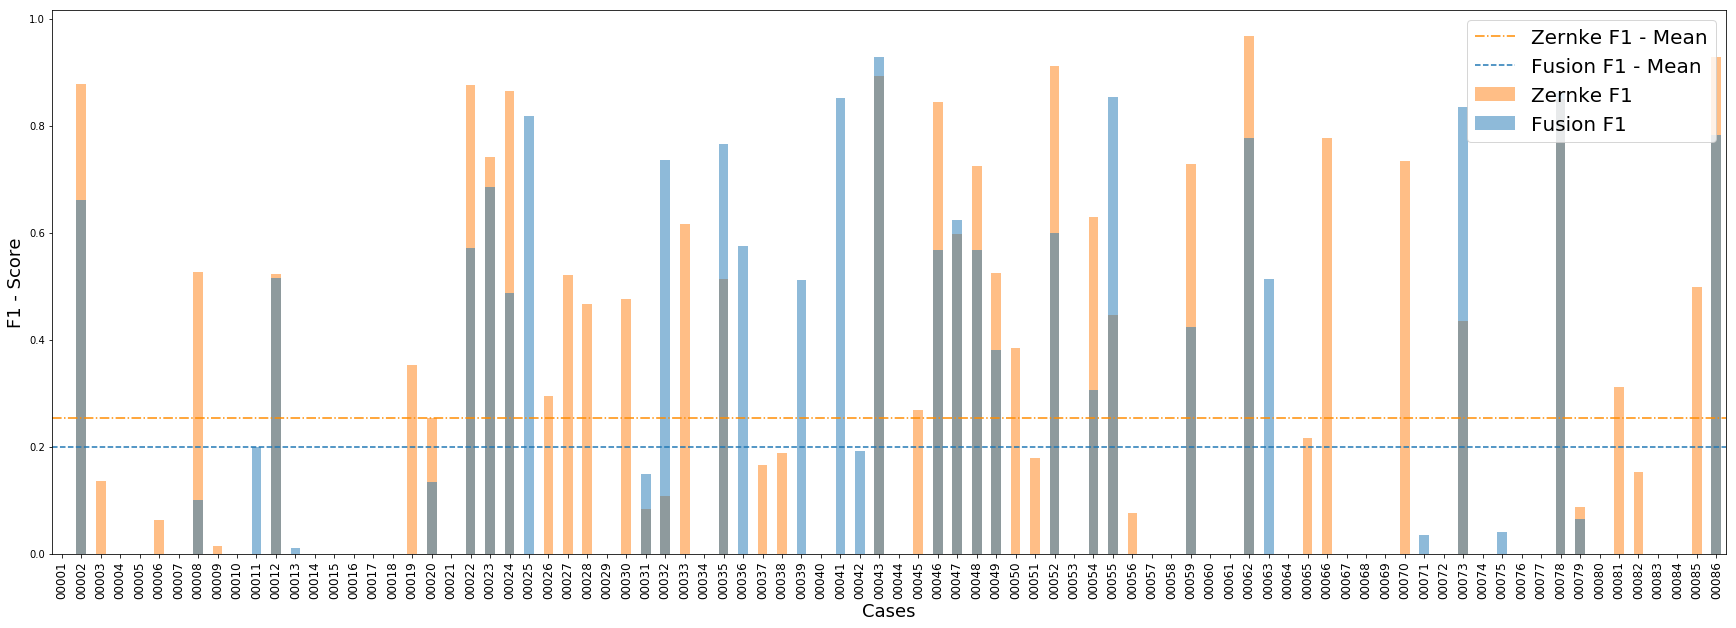

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rc('xtick', labelsize=12)
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=18)
fig, axs = plt.subplots(1,1, figsize=(30,10))

print("\t\t\t ZERNIKE PatchMatch")
zernikePM = eval_data.loc[eval_data['method'] == 'zernikePM']
f1_graph = zernikePM.plot(x='case',y='F1', ax=axs,kind='bar',color='tab:orange',alpha=0.5)
f1_graph.axhline(y=(zernikePM['F1'].mean()), color='darkorange',linestyle='dashdot', label='Zernke F1 - Mean')

fusionPM = eval_data.loc[eval_data['method'] == 'fusionPM']
fusionPM.plot(x='case',y='F1', ax=axs,color='tab:blue',kind='bar',alpha=0.5)
f1_graph.axhline(y=(fusionPM['F1'].mean()), color='tab:blue',linestyle='--', label='Fusion F1 - Mean')
handles, _ = f1_graph.get_legend_handles_labels()
labels = ["Zernke F1 - Mean","Fusion F1 - Mean","Zernke F1","Fusion F1"]
# f1_graph.legend(handles = handles, labels = labels)
f1_graph.legend(loc="upper right", labels = labels,prop={'size': 20})
plt.xlabel('Cases')
plt.ylabel('F1 - Score')
plt.savefig("F1-Score.pdf",dpi=300)
plt.show()


# Results Visualization

In [132]:
%pylab inline
from ipywidgets import interact
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


/home/jcardenu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [128]:
@interact(x=(0,len(cmfd_pixwise_setup)-1))

def f(x):
    case = list(cmfd_pixwise_setup.keys())[x]
    fig_name = os.path.basename(cmfd_pixwise_setup[case]['figure-path'])
    # Read issued img
    img_path = f"cmfd_exp/pixwise/{case}/{fig_name}"
    img = cv2.imread(img_path)
    if img is None:
        img =np.array(Image.open(img_path))
        
        
    gt_name = "gt_" +fig_name[:fig_name.rfind(".")] + '.png'
    fig_name = fig_name[:fig_name.rfind(".")] + '_out.png'

    alpha = 0.45
    beta = 1-alpha
    
    # Read Zernike output
    pm_zernike_path = f"cmfd_exp/pixwise/{case}/zernikePM/{fig_name}"
    zernike = cv2.imread(pm_zernike_path, cv2.IMREAD_COLOR)
    zernike[:,:,0] = 255
    zernike = cv2.addWeighted(img, alpha, zernike, beta, 5.0)   

    # Read Fusion output
    pm_fusion_path =  f"cmfd_exp/pixwise/{case}/fusionPM/{fig_name}"
    fusion = cv2.imread(pm_fusion_path, cv2.IMREAD_COLOR)
    fusion[:,:,0] = 255
    fusion = cv2.addWeighted(img, alpha, fusion, beta, 5.0)   

    # Read GT
    gt = cv2.imread(f"cmfd_exp/pixwise/{case}/{gt_name}", cv2.IMREAD_COLOR)
    gt[:,:,0] = 255
    gt = cv2.addWeighted(img, alpha, gt, beta, 5.0)   

    gt_path = f"cmfd_exp/pixwise/{case}/{gt_name}"
    z_res = evaluate_pixwise( gt_path, pm_zernike_path, method = 'zernikePM', case=case)
    f_res = evaluate_pixwise( gt_path, pm_fusion_path, method = 'fusionPM', case=case)
#     dst = np.uint8(alpha*(img)+beta*(gt))
    
    fig, axs = plt.subplots(1, 3, figsize=(20,5),dpi=200)
    
    axs[0].imshow(zernike);axs[0].set_title(f"F1 - ZERNIKE {z_res['F1'][0]:.03f}")
    axs[1].imshow(fusion);axs[1].set_title(f"F1 - FUSION {f_res['F1'][0]:.03f}")
    axs[2].imshow(gt);axs[2].set_title('GT')
    fig.suptitle(f'Case - {case}', fontsize=16)
    plt.show()
    
   


interactive(children=(IntSlider(value=42, description='x', max=85), Output()), _dom_classes=('widget-interact'…

			 ZERNIKE PatchMatch


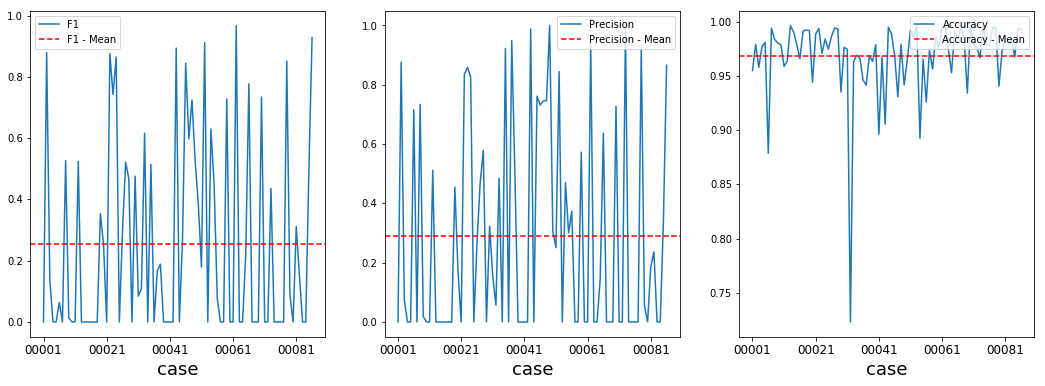

			 Fusion PatchMatch


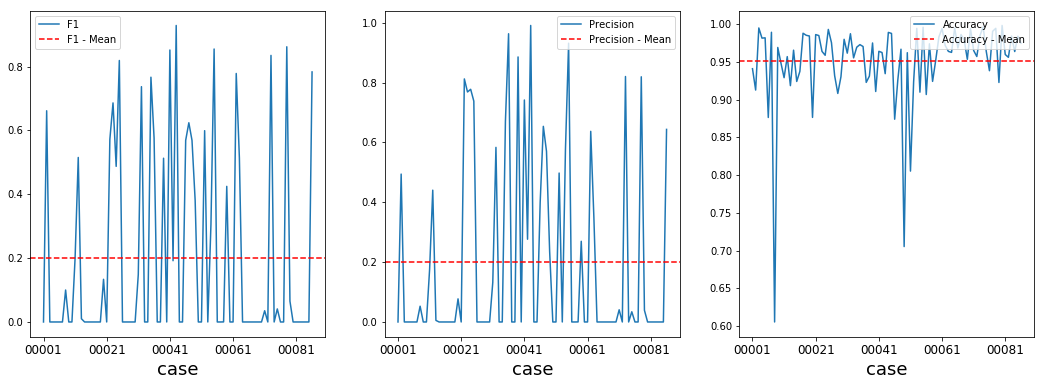

In [135]:
fig, axs = plt.subplots(1,3, figsize=(18,6))
print("\t\t\t ZERNIKE PatchMatch")
zernikePM = eval_data.loc[eval_data['method'] == 'zernikePM']
f1_graph = zernikePM.plot(x='case',y='F1', ax=axs[0])
f1_graph.axhline(y=(zernikePM['F1'].mean()), color='r',linestyle='--', label='F1 - Mean')
handles, _ = f1_graph.get_legend_handles_labels()
labels = ["F1", "F1 - Mean"]
f1_graph.legend(handles = handles, labels = labels)


p_graph = zernikePM.plot(x='case',y='Precision', ax=axs[1])
p_graph.axhline(y=(zernikePM['Precision'].mean()), color='r',linestyle='--', label='Precision - Mean')
handles, _ = p_graph.get_legend_handles_labels()
labels = ["Precision", "Precision - Mean"]
p_graph.legend(loc="upper right", labels = labels) 


p_graph = zernikePM.plot(x='case',y='Accuracy', ax=axs[2])
p_graph.axhline(y=(zernikePM['Accuracy'].mean()), color='r',linestyle='--', label='Accuracy - Mean')
handles, _ = p_graph.get_legend_handles_labels()
labels = ["Accuracy", "Accuracy - Mean"]
p_graph.legend(loc="upper right", labels = labels) 

plt.savefig("ZernikeMatch.pdf",dpi=300)
plt.savefig("ZernikeMatch.png",dpi=300)
plt.show()


fig, axs = plt.subplots(1,3, figsize=(18,6))
print("\t\t\t Fusion PatchMatch")
fusionPM = eval_data.loc[eval_data['method'] == 'fusionPM']
f1_graph = fusionPM.plot(x='case',y='F1', ax=axs[0])
f1_graph.axhline(y=(fusionPM['F1'].mean()), color='r',linestyle='--', label='F1 - Mean')
handles, _ = f1_graph.get_legend_handles_labels()
labels = ["F1", "F1 - Mean"]
f1_graph.legend(handles = handles, labels = labels)


p_graph = fusionPM.plot(x='case',y='Precision', ax=axs[1])
p_graph.axhline(y=(fusionPM['Precision'].mean()), color='r',linestyle='--', label='Precision - Mean')
handles, _ = p_graph.get_legend_handles_labels()
labels = ["Precision", "Precision - Mean"]
p_graph.legend(loc="upper right", labels = labels) 


p_graph = fusionPM.plot(x='case',y='Accuracy', ax=axs[2])
p_graph.axhline(y=(fusionPM['Accuracy'].mean()), color='r',linestyle='--', label='Accuracy - Mean')
handles, _ = p_graph.get_legend_handles_labels()
labels = ["Accuracy", "Accuracy - Mean"]
p_graph.legend(loc="upper right", labels = labels) 

plt.savefig("FusionMatch.pdf",dpi=300)
plt.savefig("FusionMatch.png",dpi=300)
plt.show()


In [136]:
fusionPM = eval_data.loc[eval_data['method'] == 'fusionPM']
zernikePM = eval_data.loc[eval_data['method'] == 'zernikePM']

In [137]:
# F1 
print(f"Zernike F1 = {zernikePM['F1'].mean():0.3f} +/- {zernikePM['F1'].std():0.3f} ")
print(f"Fusion F1 = {fusionPM['F1'].mean():0.3f} +/- {fusionPM['F1'].std():0.3f} ")

Zernike F1 = 0.254 +/- 0.321 
Fusion F1 = 0.199 +/- 0.305 


In [138]:
# print(eval_data[['True Positive Rate','True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 'Recall', 'F1', 'Accuracy','method']].groupby('method').mean().to_markdown())
# eval_data[['True Positive Rate','True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 'Recall', 'F1', 'Accuracy','method']].groupby('method').mean().applymap("{0:.2f}".format)
eval_data[['True Positive Rate','True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 'Recall', 'F1', 'Accuracy','method']].groupby('method').mean().applymap("{0:.2f}".format).to_csv("mean_pixwise_values.csv")

| method    |   True Positive Rate |   True Negative Rate |   False Positive Rate |   False Negative Rate |   Recall |   Accuracy |
|:----------|---------------------:|---------------------:|----------------------:|----------------------:|---------:|-----------:|
| fusionPM  |             0.250934 |             0.967361 |             0.0326393 |              0.749066 | 0.250934 |   0.950792 |
| zernikePM |             0.306183 |             0.987388 |             0.0126117 |              0.693817 | 0.306183 |   0.96886  |

In [139]:
# print(eval_data[['True Positive Rate','True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 'Recall', 'F1', 'Accuracy','method']].groupby('method').std().to_markdown())
eval_data[['True Positive Rate','True Negative Rate', 'False Positive Rate', 'False Negative Rate', 'Precision', 'Recall', 'F1', 'Accuracy','method']].groupby('method').std().applymap("{0:.2f}".format).to_csv("std_pixwise_values.csv")